# Noah Cina D208 Performance Assessment

## Task 2

         CaseOrder           Zip           Lat           Lng     Population  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000  49153.319600     38.757567    -90.782536    9756.562400   
std     2886.89568  27532.196108      5.437389     15.156142   14432.698671   
min        1.00000    601.000000     17.966120   -171.688150       0.000000   
25%     2500.75000  26292.500000     35.341828    -97.082812     738.000000   
50%     5000.50000  48869.500000     39.395800    -87.918800    2910.500000   
75%     7500.25000  71866.500000     42.106908    -80.088745   13168.000000   
max    10000.00000  99929.000000     70.640660    -65.667850  111850.000000   

         Children           Age         Income  Outage_sec_perweek  \
count  10000.0000  10000.000000   10000.000000        10000.000000   
mean       2.0877     53.078400   39806.926771           10.001848   
std        2.1472     20.698882   28199.916702            2.976019   
min     

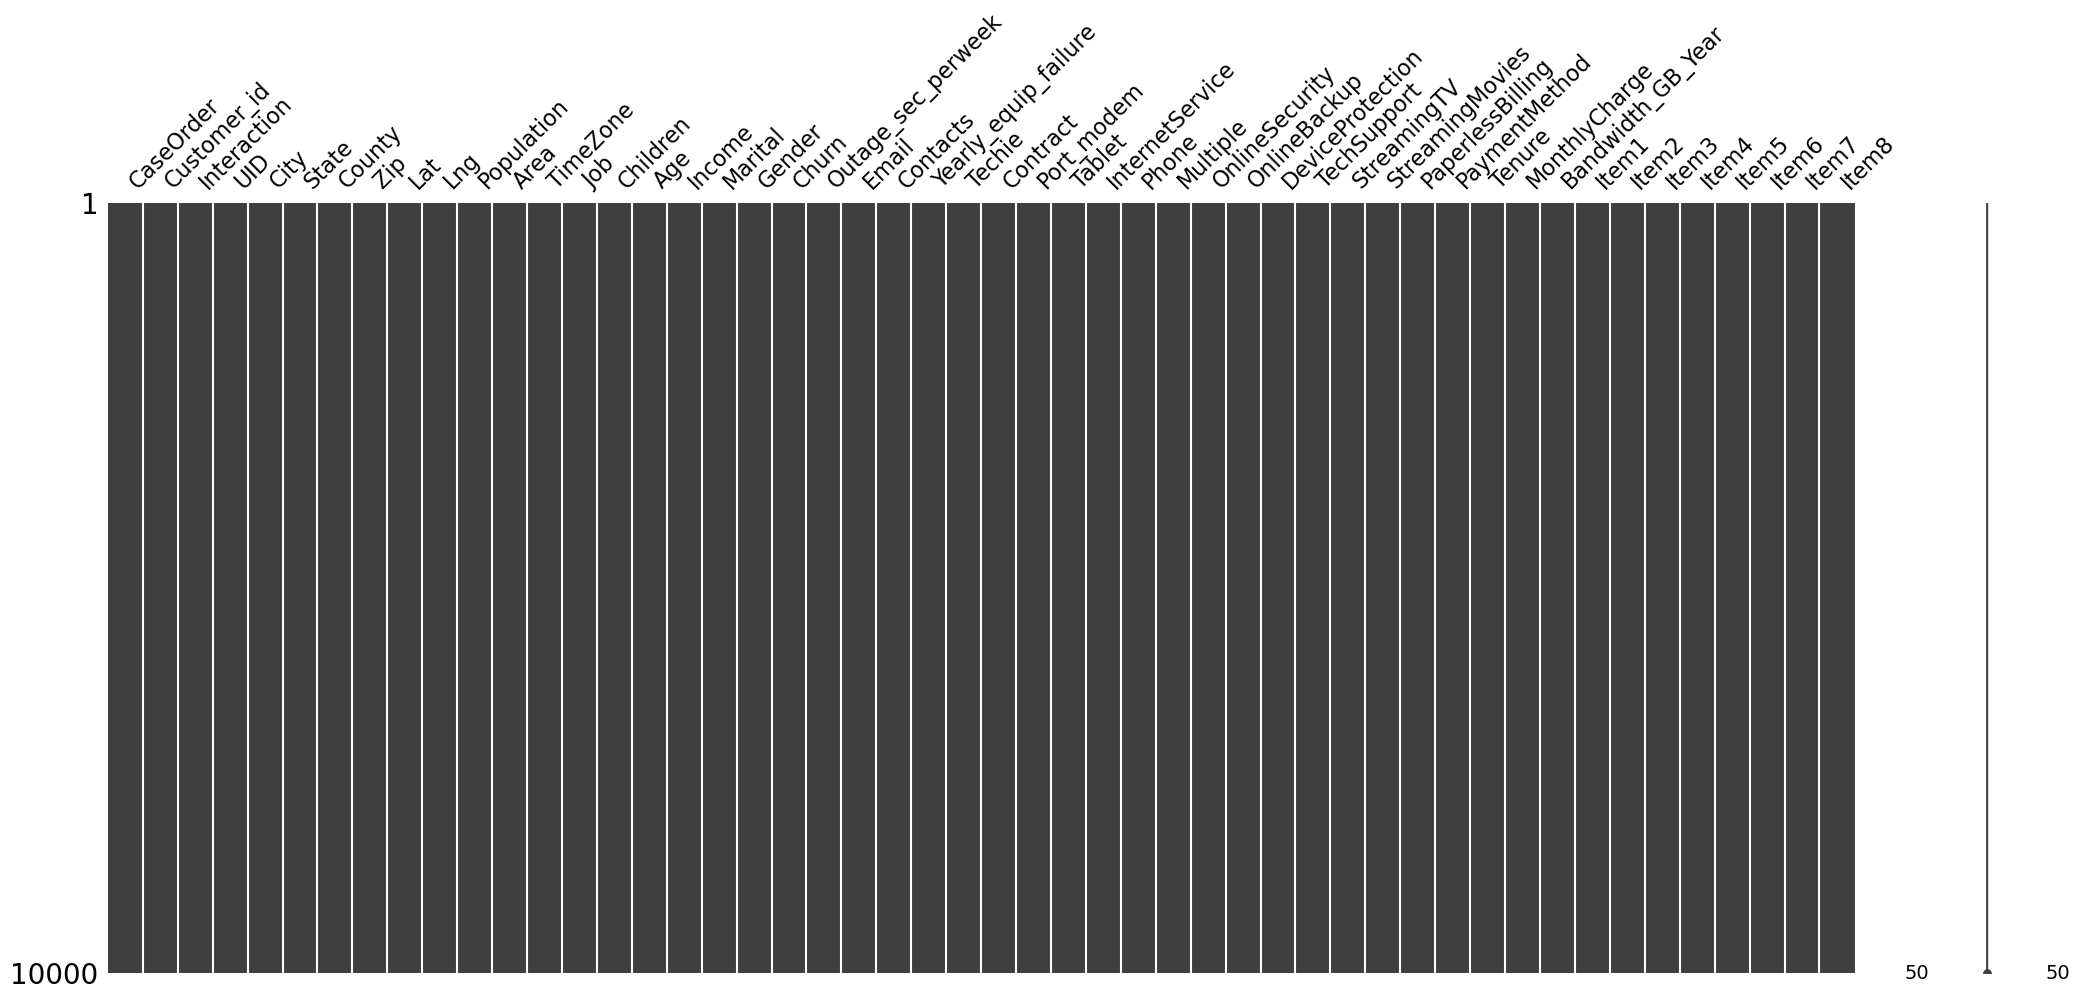

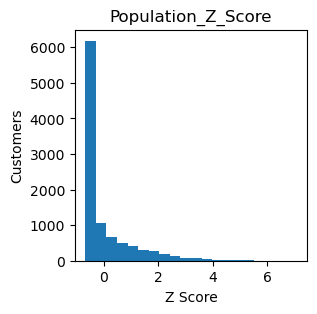

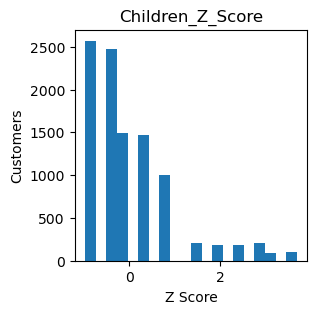

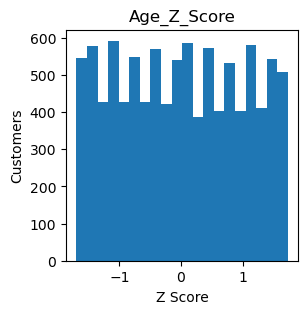

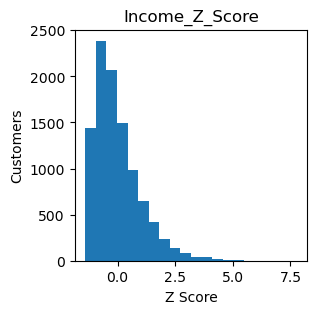

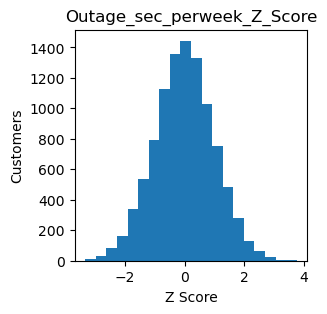

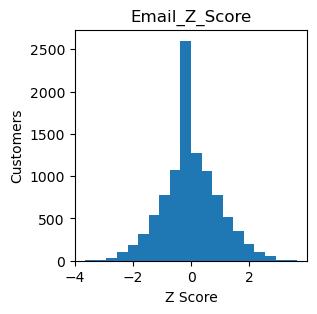

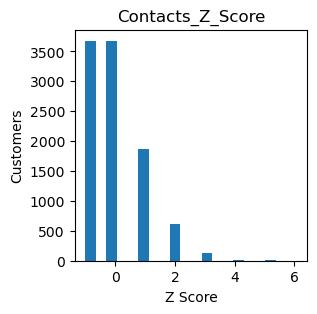

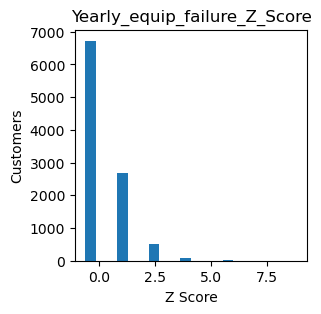

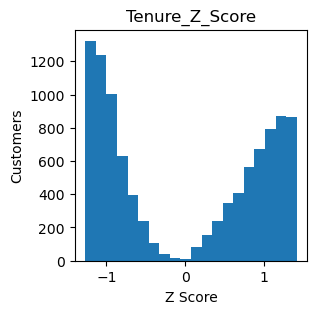

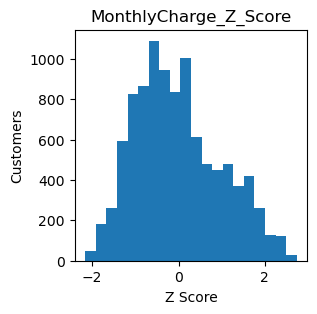

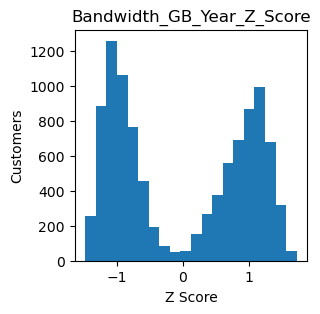

Index([  57,   90,  100,  157,  203,  212,  240,  291,  442,  445,
       ...
       9334, 9450, 9493, 9616, 9623, 9647, 9728, 9905, 9987, 9996],
      dtype='int64', length=219)
Index([  30,   97,  144,  329,  334,  346,  358,  359,  417,  480,
       ...
       9481, 9523, 9585, 9586, 9594, 9599, 9676, 9790, 9871, 9901],
      dtype='int64', length=186)
Index([], dtype='int64')
Index([  46,  130,  186,  470,  511,  513,  623,  656,  685,  688,
       ...
       9233, 9249, 9294, 9348, 9428, 9615, 9639, 9656, 9849, 9876],
      dtype='int64', length=138)
Index([ 527,  868,  908, 1022, 1334, 1904, 1997, 2250, 2927, 2984, 3629, 4184,
       4190, 4427, 4562, 4697, 5363, 5392, 5680, 6093, 6463, 7953, 8194, 8539,
       8643, 9402],
      dtype='int64')
Index([795, 1152, 1381, 1399, 1473, 1746, 6320, 7408, 8365, 8948, 9248, 9475], dtype='int64')
Index([  88,  129,  187,  205,  345,  426,  535,  567,  654,  744,
       ...
       9713, 9744, 9750, 9755, 9757, 9799, 9805, 9828, 9923, 9972],

In [1]:
#Part C1
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import missingno as msno
import scipy.stats as stats
from sklearn import linear_model
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend.feature_selection import SequentialFeatureSelector

pd.set_option('display.max_columns', None)

csv = pd.read_csv("churn_clean.csv", keep_default_na=False)
print(csv.describe(), "\n")

#Detect missing values
msno.matrix(csv)

#Detecting duplicate values
print("Complete duplicates:")
print(csv.duplicated().value_counts(), "\n")

#Detecting Outliers
#list of numerical columns to enumerate over
col_list = csv.select_dtypes(include='number').columns
col_list = col_list.drop(["CaseOrder", "Zip", "Lat", "Lng", "Item1", "Item2", "Item3", "Item4", "Item5", "Item6", "Item7", "Item8"])

csv_z_scores = pd.DataFrame()

plt.rcParams["figure.figsize"] = (3, 3)

for col in csv[col_list]:
    #generate z score
    colname = '_'.join([col, 'Z_Score'])
    csv_z_scores[colname] = stats.zscore(csv[col], nan_policy='omit')
    #plot
    plt.figure(colname)
    plt.title(colname)
    plt.xlabel("Z Score")
    plt.ylabel("Customers")
    plt.hist(csv_z_scores[colname], bins=20)

plt.show()

#drop all records with significant outliers (z > 3 or z < -3)
for col in csv_z_scores.columns:
    dropIndex = csv_z_scores.loc[(csv_z_scores[col] > 3) | (csv_z_scores[col] < -3), col].index
    print(dropIndex)
    csv.drop(dropIndex, inplace=True)
    csv_z_scores.drop(dropIndex, inplace=True)

In [2]:
#Part C4

#Re-expressing categoricals
categoricals = csv.select_dtypes(include=["object"]).columns
#Drop unneeded columns
categoricals = categoricals.drop(["Customer_id", "Interaction", "UID", "City", "State", "County", "TimeZone", "Job"])

for col in categoricals:
    #encode yes/no values to 1/0
    if csv.at[0, col] == "Yes" or csv.at[0, col] == "No":
        csv[col] = csv[col].map({"Yes" : 1, "No" : 0}).astype('bool')
        categoricals = categoricals.drop([col])
    #one-hot encode everything else
    else:
        csv = pd.concat([csv, pd.get_dummies(csv[col], prefix=col)], axis=1)
        
#drop original columns
csv.drop(columns=categoricals, inplace=True)
csv.drop(columns=csv.select_dtypes('object').columns, inplace=True)
#drop irrelevant columns
csv.drop(columns=["CaseOrder", "Item1", "Item2", "Item3", "Item4", "Item5", "Item6", "Item7", "Item8"], inplace=True)

In [3]:
#Part C2

#chi2 contingency for all categoricals on Churn
colnames = ["Churn"]
for col in csv.select_dtypes(include='bool'):
    #excluding itself
    if col == "Churn":
        continue
    #chi2
    cross = pd.crosstab(csv[col], csv["Churn"])
    values = stats.chi2_contingency(cross)
    if values[1] < 0.05: #significant p value
        print(col, "P:", values[1].round(2))
        colnames.append(col)

#point biserial r for all continuous on churn
for col in csv.select_dtypes(exclude='bool'):
    values = stats.pointbiserialr(csv[col], csv["Churn"])
    if values[1] < 0.05: #significant p value
        print(col, "P:", values[1].round(2))
        colnames.append(col)

#subset only on relevant columns
csv = csv[colnames]

for col in csv.select_dtypes(include='bool'):
    print(csv[col].value_counts() / csv[col].shape[0] * 100, "\n")

Techie P: 0.0
Phone P: 0.01
Multiple P: 0.0
OnlineBackup P: 0.0
DeviceProtection P: 0.0
TechSupport P: 0.04
StreamingTV P: 0.0
StreamingMovies P: 0.0
Gender_Female P: 0.01
Gender_Male P: 0.01
Contract_Month-to-month P: 0.0
Contract_One year P: 0.0
Contract_Two Year P: 0.0
InternetService_DSL P: 0.0
InternetService_Fiber Optic P: 0.0
InternetService_None P: 0.0
PaymentMethod_Electronic Check P: 0.0
Tenure P: 0.0
MonthlyCharge P: 0.0
Bandwidth_GB_Year P: 0.0
Churn
False    73.449591
True     26.550409
Name: count, dtype: float64 

Techie
False    83.215259
True     16.784741
Name: count, dtype: float64 

Phone
True     90.594005
False     9.405995
Name: count, dtype: float64 

Multiple
False    53.504087
True     46.495913
Name: count, dtype: float64 

OnlineBackup
False    54.877384
True     45.122616
Name: count, dtype: float64 

DeviceProtection
False    56.26158
True     43.73842
Name: count, dtype: float64 

TechSupport
False    62.604905
True     37.395095
Name: count, dtype: float

Univariate visualizations:


c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


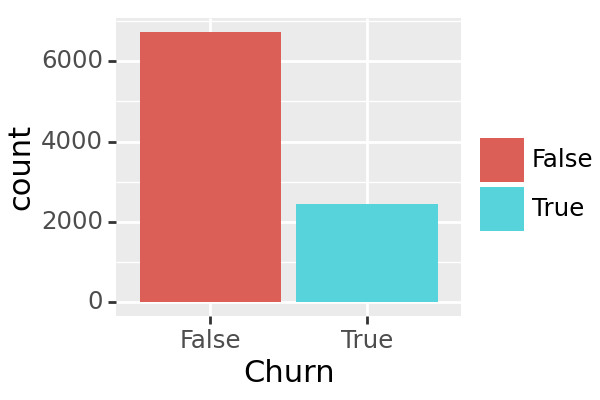

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


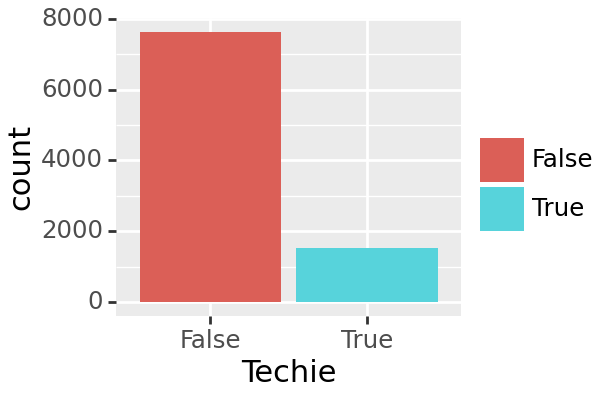

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


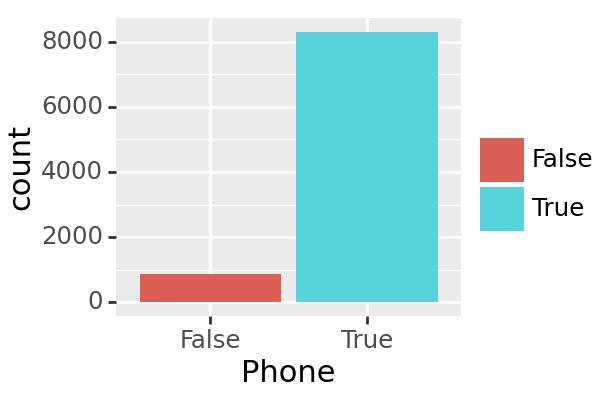

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


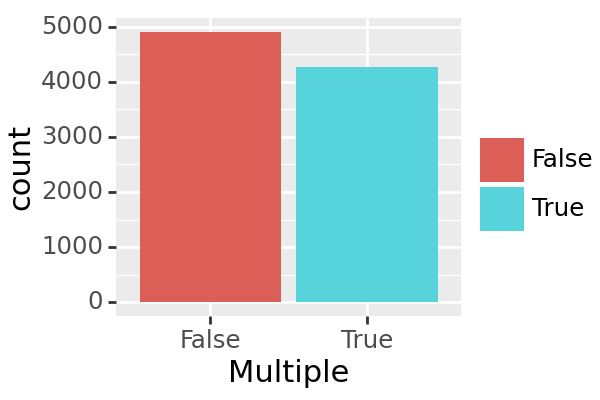

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


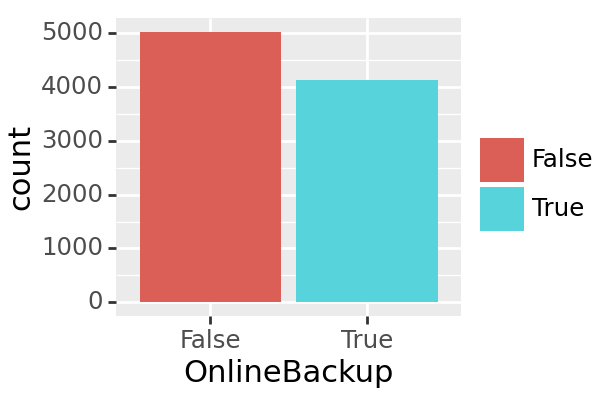

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


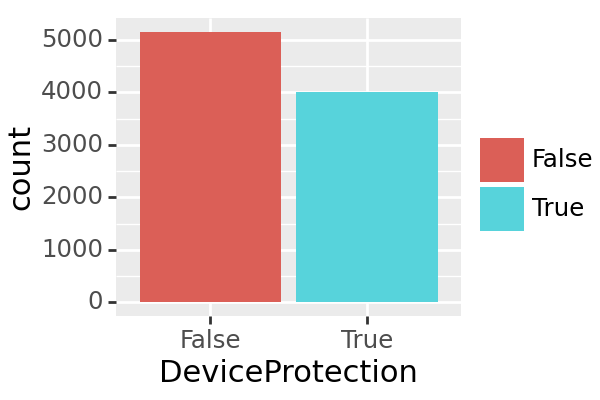

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


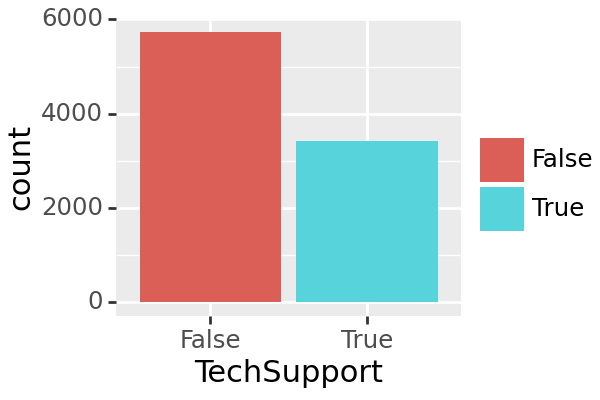

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


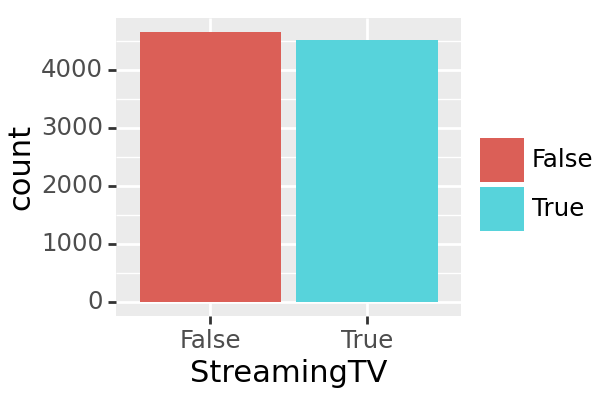

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


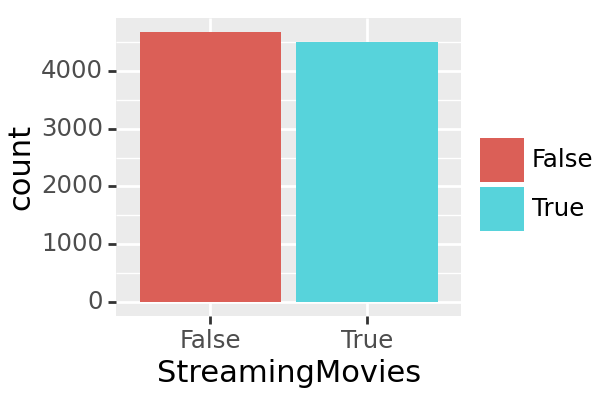

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


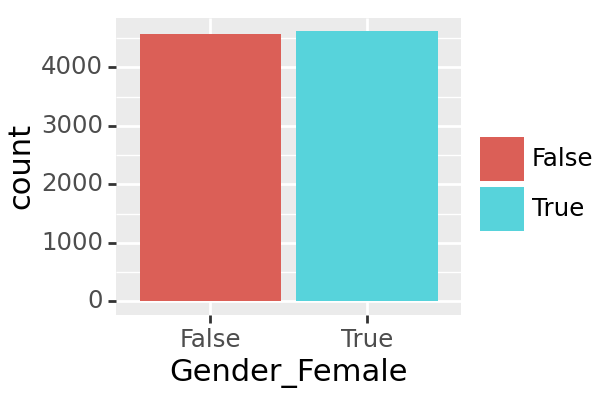

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


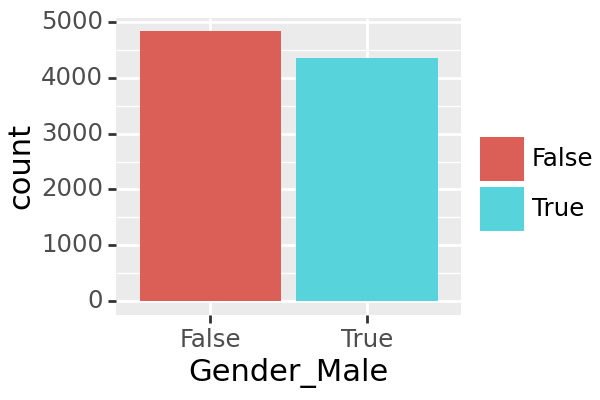

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


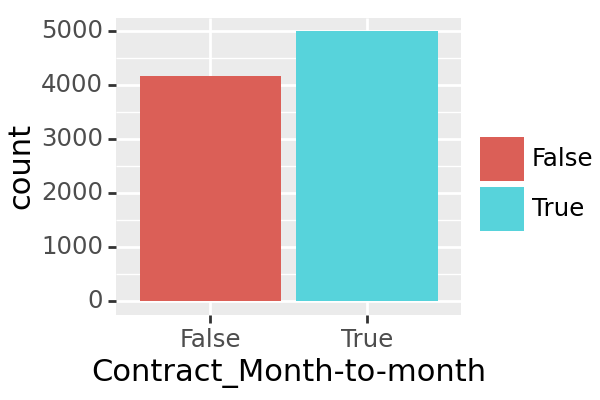

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


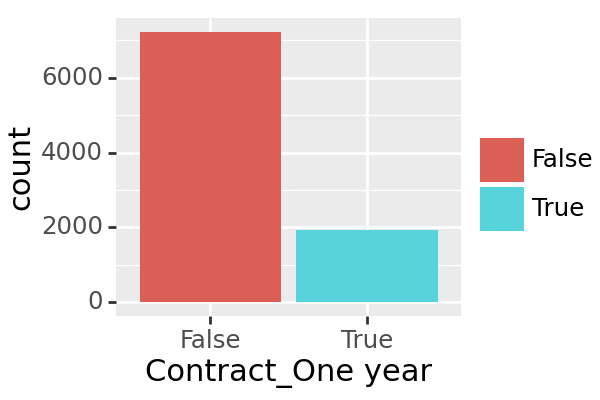

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


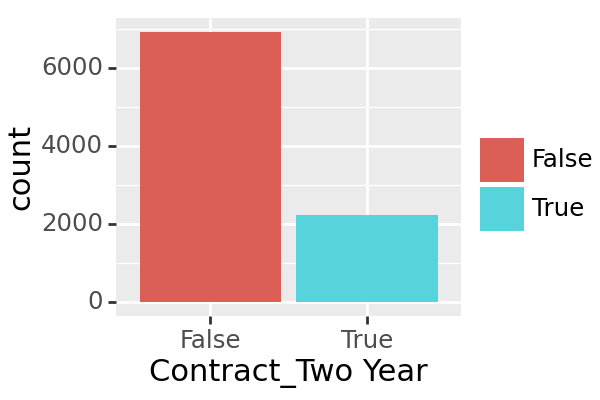

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


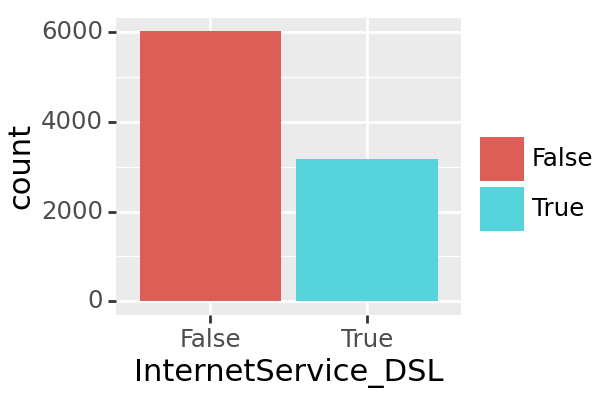

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


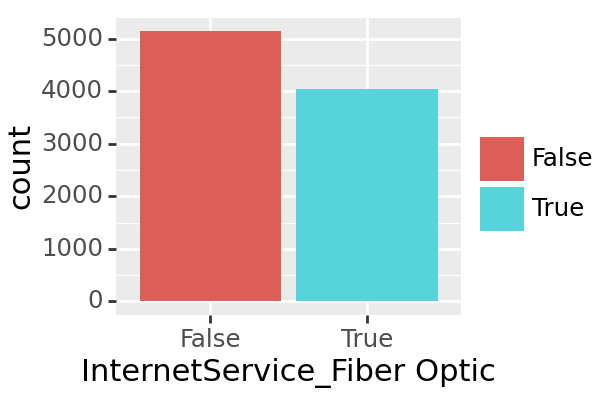

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


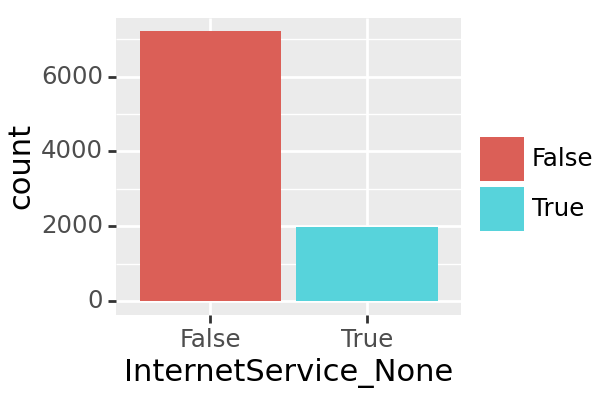

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


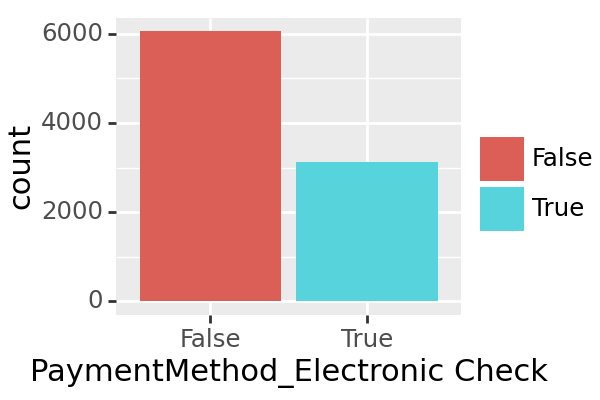

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.


c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


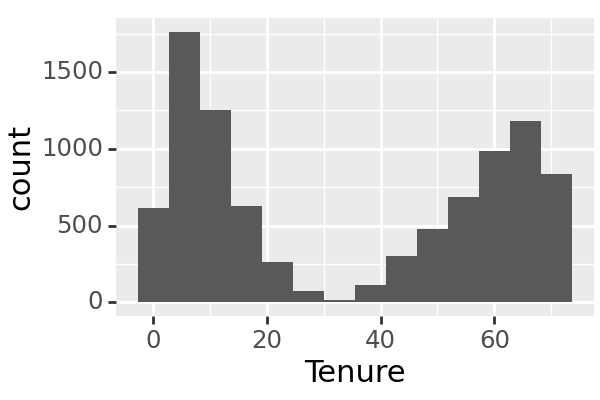

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 36'. Pick better value with 'binwidth'.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


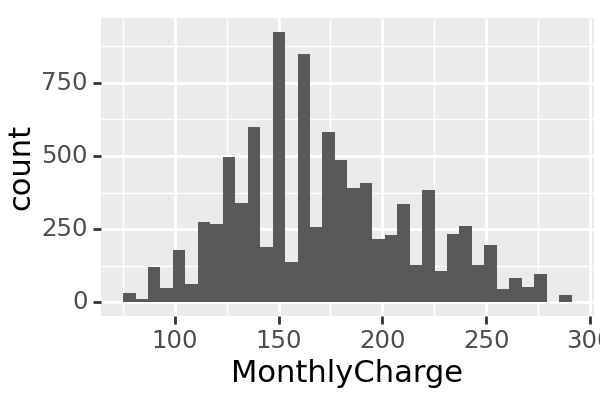

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


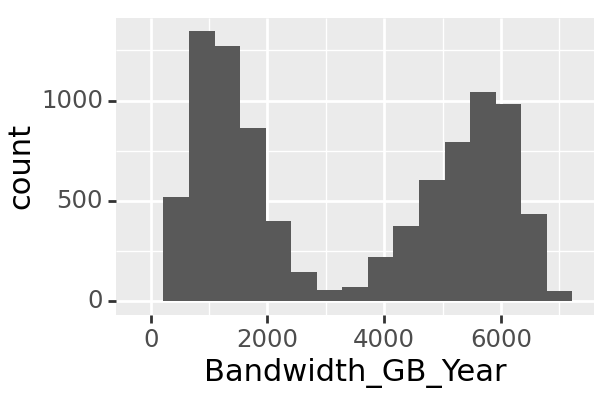


Bivariate visualizations:


c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

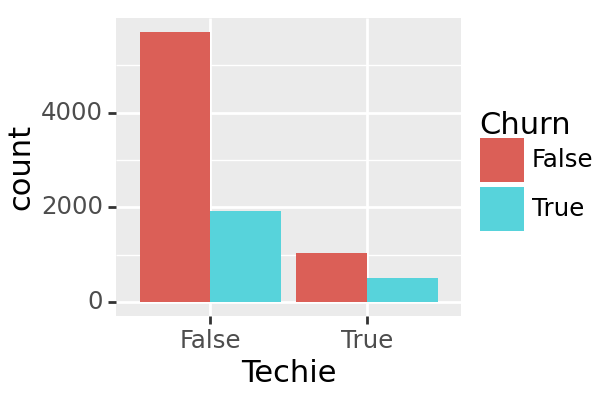

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

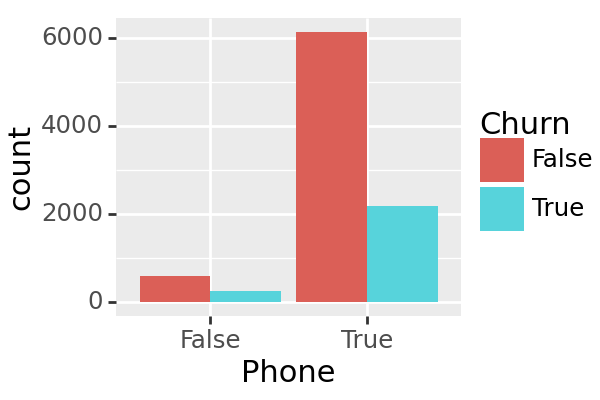

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

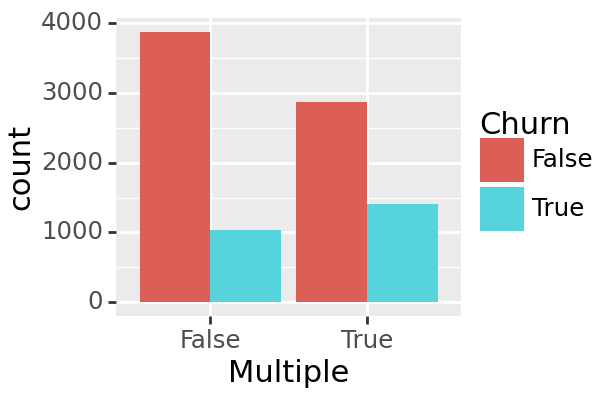

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

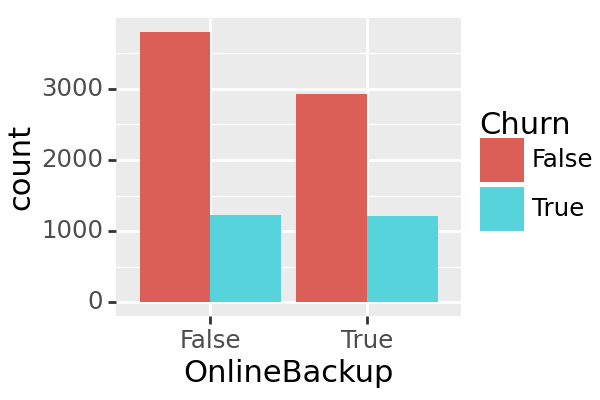

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

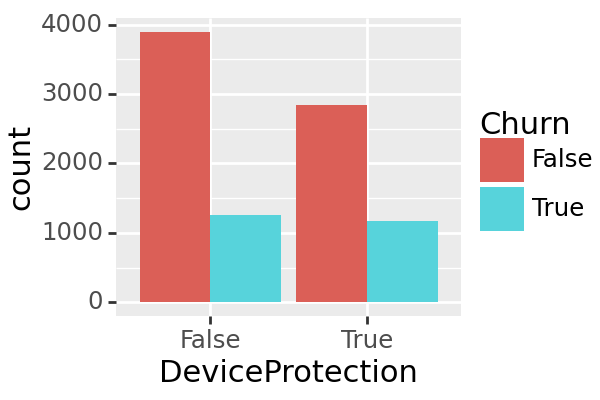

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

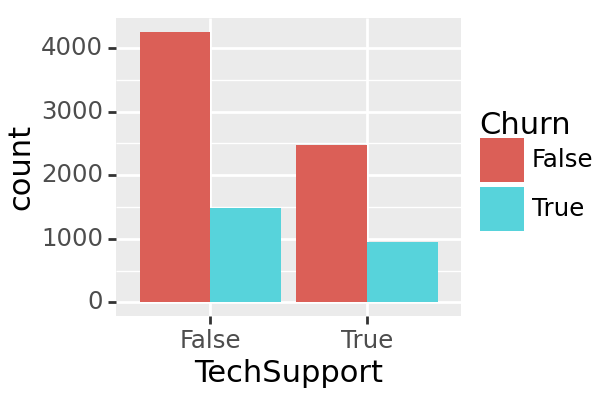

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

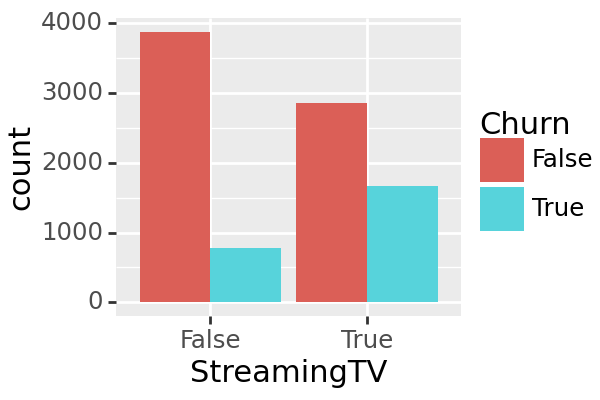

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

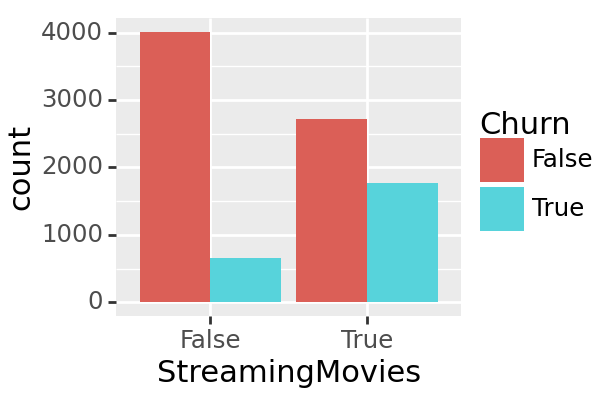

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

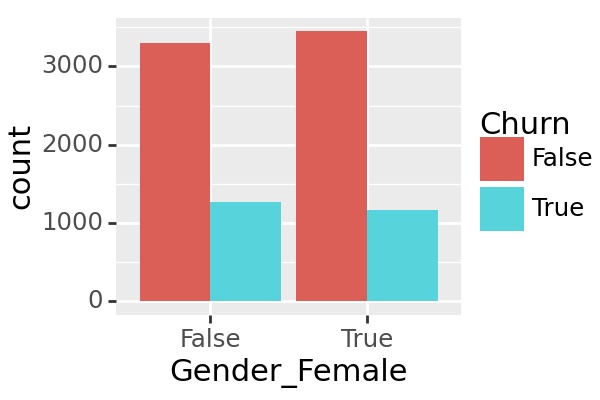

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

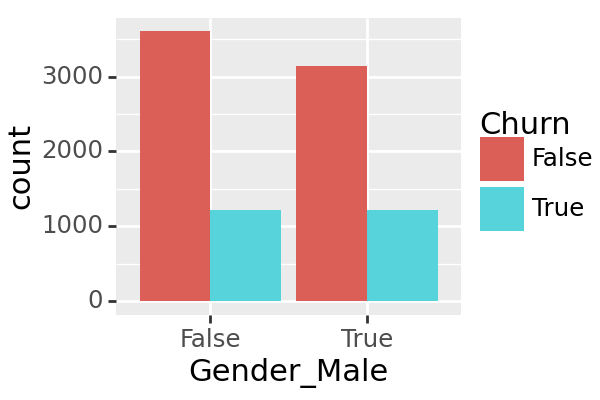

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

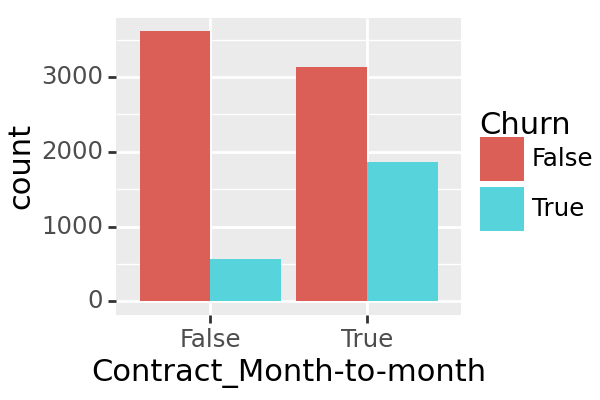

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

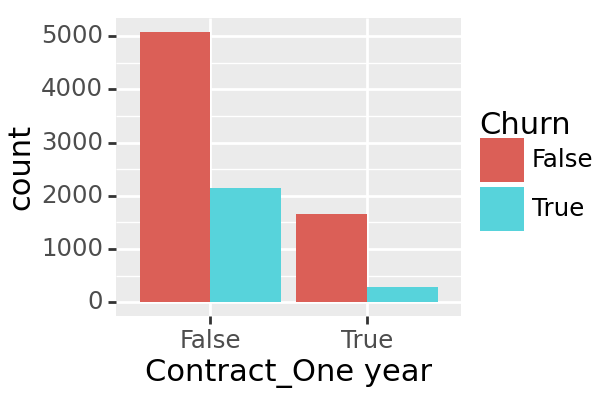

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

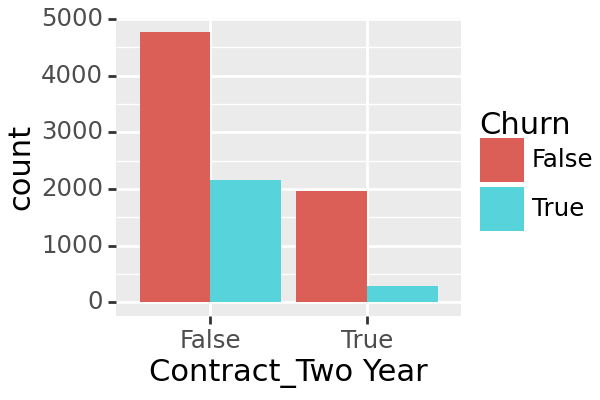

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

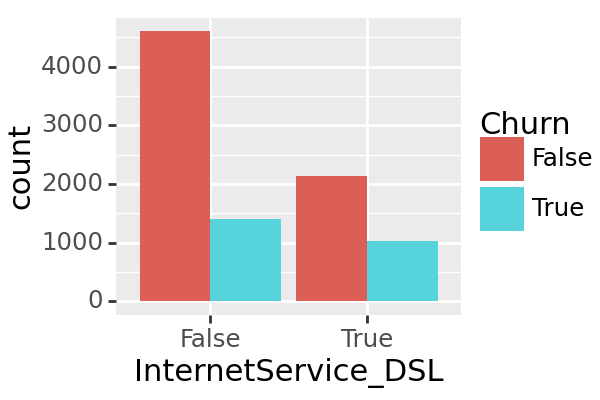

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

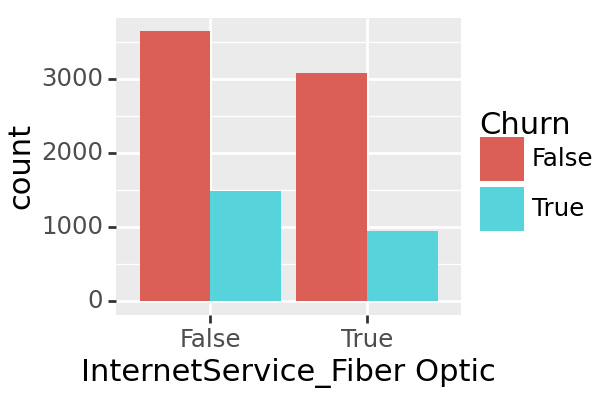

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

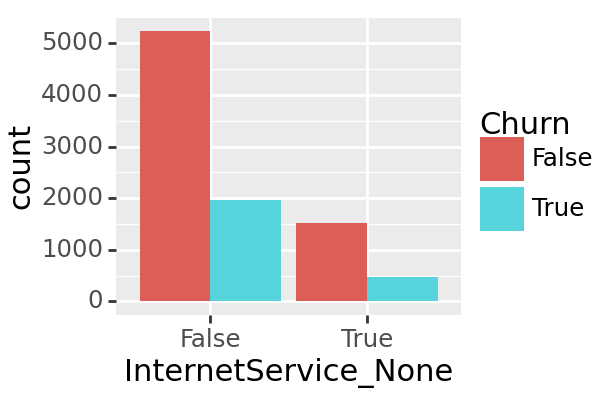

c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda3\Lib\site-packages\plotnine\stats\stat_count.py:70: FutureWarning: The provided callable <function sum at 0x000001C17BC90360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
c:\Users\Mugenri\anaconda

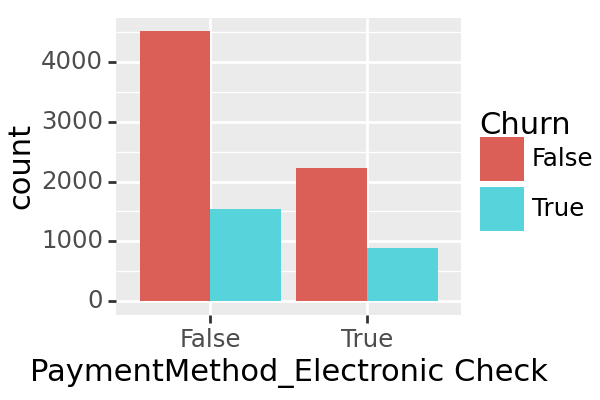

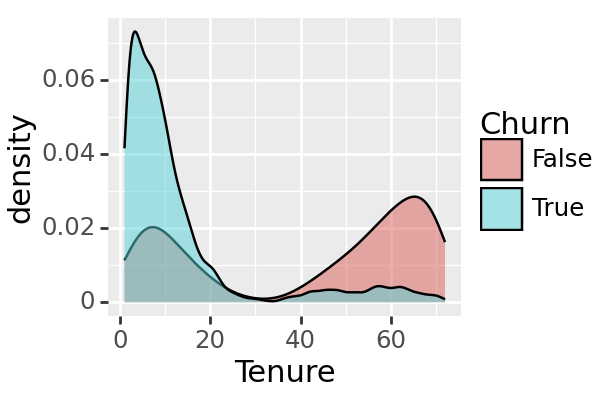

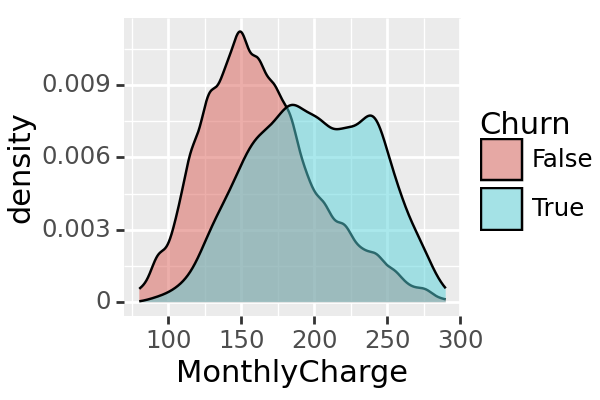

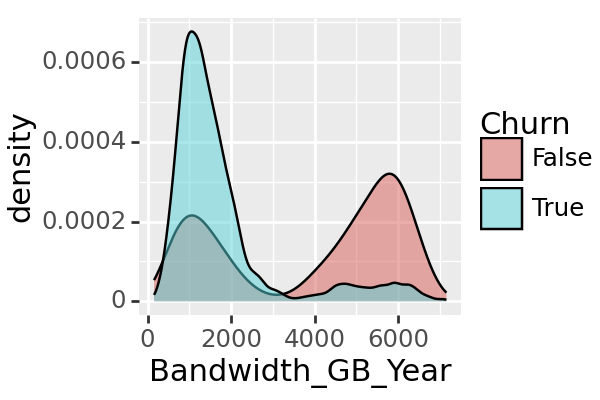

In [4]:
#Part C3

#Univariate visualizations
print("Univariate visualizations:")
for col in csv.select_dtypes(include='bool'):
    print(p9.ggplot(csv) + p9.aes(x=col, fill=col) + p9.geom_bar() + p9.theme(figure_size=(3, 2)) + p9.labs(fill=""))

for col in csv.select_dtypes(exclude='bool'):
    print(p9.ggplot(csv) + p9.aes(x=col) + p9.geom_histogram() + p9.theme(figure_size=(3, 2)))

#Bivariate visualizations
print("Bivariate visualizations:")
for col in csv.select_dtypes(include='bool'):
    if col == "Churn":
        continue
    print(p9.ggplot(csv) + p9.aes(x=col, fill="Churn") + p9.geom_bar(position="dodge") + p9.theme(figure_size=(3, 2)))

for col in csv.select_dtypes(exclude='bool'):
    print(p9.ggplot(csv) + p9.aes(x=col, fill="Churn") + p9.geom_density(alpha=0.5) + p9.theme(figure_size=(3, 2)))

In [5]:
#Part C5

csv.to_csv("NCina D208 T2.csv")

In [6]:
#Part D1

#convert to int
for col in csv.select_dtypes(include='bool'):
    csv.replace({False: 0, True: 1}, inplace=True)

csv.rename(columns={"Contract_Month-to-month" : "Contract_Month_to_Month", "Contract_One year" : "Contract_One_Year", "Contract_Two Year" : "Contract_Two_Year", "InternetService_Fiber Optic" : "InternetService_Fiber_Optic", "PaymentMethod_Electronic Check" : "PaymentMethod_Electronic_Check"}, inplace=True)
mlr_model = logit("Churn ~ C(Techie) + C(Phone) + C(Multiple) + C(OnlineBackup) + C(DeviceProtection) + C(TechSupport) + C(StreamingTV) + C(StreamingMovies) + C(Gender_Female) + C(Gender_Male) + C(Contract_Month_to_Month) + C(Contract_One_Year) + C(Contract_Two_Year) + C(InternetService_DSL) + C(InternetService_Fiber_Optic) + C(InternetService_None) + C(PaymentMethod_Electronic_Check) + Tenure + MonthlyCharge + Bandwidth_GB_Year", data=csv).fit()

print(mlr_model.summary())

Optimization terminated successfully.
         Current function value: 0.218347
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 9175
Model:                          Logit   Df Residuals:                     9155
Method:                           MLE   Df Model:                           19
Date:                Wed, 05 Jun 2024   Pseudo R-squ.:                  0.6227
Time:                        17:24:09   Log-Likelihood:                -2003.3
converged:                       True   LL-Null:                       -5309.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -4.9332  

In [7]:
#Part D2

#multicollinearity reduction by VIF
pd.options.mode.copy_on_write = True
#select all columns except dependent variable
csv_vif = csv.drop(["Churn"], axis=1)

def do_vif(dataFrame):
    vif = pd.DataFrame()
    vif["Variable Name"] = dataFrame.columns
    vif["VIF"] = [variance_inflation_factor(dataFrame.values, i)
              for i in range(len(dataFrame.columns))]
    print(vif, "\n")

#initial VIF
do_vif(csv_vif)

#Subsequent VIF until all values are < 10
csv_vif = csv_vif.drop(["Gender_Male"], axis=1)
do_vif(csv_vif)
csv_vif = csv_vif.drop(["Contract_Month_to_Month"], axis=1)
do_vif(csv_vif)
csv_vif = csv_vif.drop(["InternetService_DSL"], axis=1)
do_vif(csv_vif)
csv_vif = csv_vif.drop(["MonthlyCharge"], axis=1)
do_vif(csv_vif)
csv_vif = csv_vif.drop(["Bandwidth_GB_Year"], axis=1)
do_vif(csv_vif)

csv = csv.drop(["Gender_Male", "Contract_Month_to_Month", "InternetService_DSL", "MonthlyCharge", "Bandwidth_GB_Year"], axis=1)

c:\Users\Mugenri\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
c:\Users\Mugenri\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide


                     Variable Name         VIF
0                           Techie    1.001538
1                            Phone    1.002347
2                         Multiple    4.394602
3                     OnlineBackup    2.608453
4                 DeviceProtection    1.539220
5                      TechSupport    1.515098
6                      StreamingTV    6.860054
7                  StreamingMovies    9.712151
8                    Gender_Female   11.236399
9                      Gender_Male   11.370186
10         Contract_Month_to_Month         inf
11               Contract_One_Year         inf
12               Contract_Two_Year         inf
13             InternetService_DSL         inf
14     InternetService_Fiber_Optic         inf
15            InternetService_None         inf
16  PaymentMethod_Electronic_Check    1.001257
17                          Tenure  504.823051
18                   MonthlyCharge   25.654053
19               Bandwidth_GB_Year  513.298823 

           

In [8]:
#Part D2 continued

#Model reduction via Stepwise Regression using Sequential Forward Selection
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(), k_features=5, scoring='accuracy', cv=None)
features = sfs.fit(csv.drop(["Churn"], axis=1), csv.Churn.values)

#list of best 5 features and the prediction score
print("Best 5 Features:", features.k_feature_names_)
print("Prediction Score:", features.k_score_)

Best 5 Features: ('StreamingTV', 'StreamingMovies', 'Contract_One_Year', 'Contract_Two_Year', 'Tenure')
Prediction Score: 0.8801089918256131


In [9]:
#Part D3

mlr_model_reduced = logit("Churn ~ C(StreamingTV) + C(StreamingMovies) + C(Contract_One_Year) + C(Contract_Two_Year) + Tenure", data=csv).fit()
print(mlr_model_reduced.summary())

Optimization terminated successfully.
         Current function value: 0.273168
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 9175
Model:                          Logit   Df Residuals:                     9169
Method:                           MLE   Df Model:                            5
Date:                Wed, 05 Jun 2024   Pseudo R-squ.:                  0.5280
Time:                        17:24:11   Log-Likelihood:                -2506.3
converged:                       True   LL-Null:                       -5309.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.7585      0.076     -9.973      0.000      -0.

In [10]:
#Part E2
pt = mlr_model_reduced.pred_table()
print("Confusion Matrix: \n", pt, "\n")

TP = pt[0][0]
TN = pt[1][1]
FP = pt[0][1]
FN = pt[1][0]
acc = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", acc)

Confusion Matrix: 
 [[6209.  530.]
 [ 572. 1864.]] 

Accuracy:  0.8798910081743869
